## LALR testing for sBQC loss

In [23]:
# My imports
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from adahessian import Adahessian, get_params_grad
import torch.optim.lr_scheduler as lr_scheduler
import math
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

# Other imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import warnings
import matplotlib.pyplot as plt
# import shap

In [24]:
# Loss function code:

def bareCDF(yhat, tau):
    # yhat is a torch tensor, tau is a float
    ind= (torch.sign(yhat)+1)/2 # mask about the origin
    quantFactor= (1-tau)*ind + tau*(1-ind)
    val= tau+4*quantFactor/math.pi*torch.atan(torch.tanh(yhat/2))
    # print("bareCDF val: {}".format(val))
    return val

def baresBQR(y, yhat, tau):
    # y and yhat are torch tensors, tau is a float
    test= bareCDF(yhat, tau)
    val= y*torch.log(1-bareCDF(yhat, tau))+(1-y)*torch.log(bareCDF(yhat, tau))
    # print("bareBQR val: {}".format(val))
    return val

class sBQRL(nn.Module):
    def __init__(self):
        super(sBQRL, self).__init__()
    
    def forward(self, y, yhat, tau):
        return torch.mean(baresBQR(y, yhat, tau))


In [25]:
# Data code:
dataset= "./Datasets/Classification/pima.csv"
x_cols = list(range(8)) # 13,8
y_col = 8 # 13,8

attribute_index = 5  # This controls which attribute is allowed to vary, 7,5
attribute_name = "BMI" # Name of the attribute, used in the plots, max heart rate
latent_name = "Diabetes" # Name of the function, used in the plots
# The other attributes are replaced by the median value of the attribute
Scaler= StandardScaler()
batch_is= 64

total_epochs = 20

### 
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, ditch_head=True):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        X.append(point)
        Y.append(float(all_columns[target_column]))
    X_arr = np.asarray(X)
    X_unscaled = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = 0
    Y_arr_binary = np.where(Y_arr<=thresh,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, X_unscaled

###
X_train,X_val,y_train,y_val, data_Y, data_X_scaled, data_X_unscaled = create_xy(dataset, x_cols, y_col, ",", 0.4)
shap_x_train = X_train.copy()
shap_x_val = X_val.copy()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
# y_train= F.one_hot(y_train.to(torch.int64), num_classes=2)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
# y_val= F.one_hot(y_val.to(torch.int64), num_classes=2)
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =batch_is,pin_memory=True,shuffle = False,num_workers = 1)

In [26]:
# Network definition:
class LALRnetwork(nn.Module):
    def __init__(self, indim):
        super(LALRnetwork,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,10)
        self.l3 = nn.Linear(10,1)
        
    def forward(self,x):
        x = F.tanh(self.l1(x))
        x = F.tanh(self.l2(x))
        # x = F.softmax(self.l3(x))
        x = F.sigmoid(self.l3(x))
        # x= torch.sign(x-torch.ones_like(x)*0.5)
        # x= (x+torch.ones_like(x))/2
        return x
    
    # Used in LALR
    def penU(self, x):
        op = F.tanh(self.l1(x))
        op = F.tanh(self.l2(op))
        return op


In [31]:
# Global initialisations:
device= ('cuda' if torch.cuda.is_available() else 'cpu')
indim = X_train.shape[1]
modelLALR_sBQC = LALRnetwork(indim).to(device)
modelCLR_sBQC= LALRnetwork(indim).to(device)
modelLALR_BCE= LALRnetwork(indim).to(device)
modelCLR_BCE= LALRnetwork(indim).to(device)
criterion= sBQRL()
criterion_= nn.BCELoss()
h= 0.4
lr_is = 1e-2
optimizerLALR_sBQC= torch.optim.SGD(modelLALR_sBQC.parameters(), lr = lr_is)
optimizerLALR_BCE= torch.optim.SGD(modelLALR_BCE.parameters(), lr = lr_is)
optimizerCLR_sBQC= torch.optim.SGD(modelCLR_sBQC.parameters(), lr = lr_is)
optimizerCLR_BCE= torch.optim.SGD(modelCLR_BCE.parameters(), lr = lr_is)

all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0
tau= 0.2

ls_list_LALR_sBQC= []
val_list_LALR_sBQC= []
acc_list_LALR_sBQC= []
ls_list_CLR_sBQC= []
val_list_CLR_sBQC= []
acc_list_CLR_sBQC= []
ls_list_LALR_BCE= []
val_list_LALR_BCE= []
acc_list_LALR_BCE= []
ls_list_CLR_BCE= []
val_list_CLR_BCE= []
acc_list_CLR_BCE= []

In [32]:
# training loops:
def trainConstantLR(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, loss_name= "sBQC"):
    """
    Training loop used for CLR training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            # loss= criterion(torch.unsqueeze(labels, 1), outputs, tau) 
            # print(outputs, labels)
            # outputs= outputs.to(torch.LongTensor()).to(device)
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            # loss= criterion(outputs, labels) # works for one hot encoding and BCE
            # loss= criterion(outputs, torch.unsqueeze(labels, 1))#, tau) 
            loss.backward() 
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            # x= outputs
            # x= torch.sign(x-torch.ones_like(x)*0.5)
            # x= (x+torch.ones_like(x))/2
            # print(x==labels)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader),
         float(num_correct)/float(total)*100))


def trainLALR(model, trainLoader, valLoader, optimizer, criterion, tau, epochs, ls_list, valList, acc_list, mask, loss_name= "sBQC"):
    """
    Training loop used for LALR training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        lr_val= computeLR(model,train_loader, mask, tau, bSize= batch_is)
        optimizer.param_groups[0]['lr']= lr_val
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            if loss_name== "BCE":
                loss= criterion(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            loss.backward() 
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        num_correct= 0
        total= 0 
        model.eval()
        for inputs, labels in valLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            if loss_name== "BCE":
                loss= criterion_(outputs.view(outputs.shape[0],), labels) # For BCE
            elif loss_name== "sBQC":
                loss= criterion(labels, outputs.view(outputs.shape[0],), tau) # For sBQC
            val_loss+= loss.item()
            x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
            num_correct += (x==labels).sum()
            total += labels.size(0)
        valList.append(val_loss/len(valLoader))
        acc_list.append(float(num_correct)/float(total)*100)
        print("Epoch: {} Training Loss: {} Validation loss: {} LR: {} Accuracy: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(valLoader), optimizer.param_groups[0]['lr'], float(num_correct)/float(total)*100))

def computeLR(model, trainLoader, mask, tau, bSize= 16):
    """
    Takes in a network of the LALRnetwork class(during some arbitrary EPOCH of training) and the current input, and returns Kz for the EPOCH
    """
    Kz = 0.0
    model.eval()
    with torch.no_grad():
        for i,j in enumerate(trainLoader):
            inputs,labels= j[0],j[1]
            inputs= inputs.to(device)
            labels= labels.to(device)
            op1= model.penU(inputs)
            # first taking the max and min for each batch
            activ1, indx1= torch.max(op1, dim= 1)
            # now, we take the max and min across batches
            val1, indx2= torch.max(activ1, dim= 0)
            # print(indx, i)
            if val1 > Kz:
                # in the case of K_z, we do not need the index where the max occurs, hence only deal with the value
                Kz= val1 
    factor= 1
    if mask == 1:
        factor =  max(2/math.pi, 2-2*tau/(math.pi*tau))#, 2*tau/(math.pi*(1-tau)))
    else:
        factor= 0.5
    LR= (factor*Kz)/bSize
    # if LR == 0:
    #     return 0.1
    return (1/LR)*0.001

In [45]:
# LALR, sBQC
trainLALR(modelLALR_sBQC, train_loader, test_loader, optimizerLALR_sBQC, criterion, tau, 10, ls_list_LALR_sBQC, val_list_LALR_sBQC, acc_list_LALR_sBQC, 1, "sBQC")

Epoch: 0 Training Loss: -1.1355736404657364 Validation loss: -1.1529963970184327 LR: 0.04724797233939171 Accuracy: 75.0
Epoch: 1 Training Loss: -1.1573114842176437 Validation loss: -1.1543177127838136 LR: 0.04723072052001953 Accuracy: 75.0
Epoch: 2 Training Loss: -1.1704892665147781 Validation loss: -1.1552638053894042 LR: 0.04721257463097572 Accuracy: 74.67532467532467
Epoch: 3 Training Loss: -1.1688228994607925 Validation loss: -1.1562403440475464 LR: 0.04719875380396843 Accuracy: 74.67532467532467
Epoch: 4 Training Loss: -1.1688319593667984 Validation loss: -1.1567120790481566 LR: 0.04718543961644173 Accuracy: 74.67532467532467
Epoch: 5 Training Loss: -1.1333882883191109 Validation loss: -1.1576577186584474 LR: 0.04717012122273445 Accuracy: 74.67532467532467
Epoch: 6 Training Loss: -1.1373347714543343 Validation loss: -1.1590315341949462 LR: 0.04715796560049057 Accuracy: 74.67532467532467
Epoch: 7 Training Loss: -1.1541241854429245 Validation loss: -1.1603663682937622 LR: 0.04714595

In [46]:
# LALR, BCE
trainLALR(modelLALR_BCE, train_loader, test_loader, optimizerLALR_BCE, criterion_, tau, 10, ls_list_LALR_BCE, val_list_LALR_BCE, acc_list_LALR_BCE, 2, "BCE")

Epoch: 0 Training Loss: 0.4746115244925022 Validation loss: 0.42679556012153624 LR: 0.132788747549057 Accuracy: 81.4935064935065
Epoch: 1 Training Loss: 0.516699779778719 Validation loss: 0.42954443097114564 LR: 0.13159477710723877 Accuracy: 81.16883116883116
Epoch: 2 Training Loss: 0.4932515285909176 Validation loss: 0.42939119338989257 LR: 0.13209517300128937 Accuracy: 82.14285714285714
Epoch: 3 Training Loss: 0.4856507107615471 Validation loss: 0.4322864055633545 LR: 0.13217946887016296 Accuracy: 80.51948051948052
Epoch: 4 Training Loss: 0.49688638374209404 Validation loss: 0.4267978370189667 LR: 0.1316411793231964 Accuracy: 81.81818181818183
Epoch: 5 Training Loss: 0.47215772792696953 Validation loss: 0.4256918549537659 LR: 0.13171322643756866 Accuracy: 81.4935064935065
Epoch: 6 Training Loss: 0.4647515192627907 Validation loss: 0.4272987425327301 LR: 0.13168056309223175 Accuracy: 80.51948051948052
Epoch: 7 Training Loss: 0.4632263034582138 Validation loss: 0.42952250242233275 LR: 

In [47]:
# CLR, sBQC
trainConstantLR(modelCLR_sBQC, train_loader, test_loader, optimizerCLR_sBQC, criterion, tau, 10, ls_list_CLR_sBQC, val_list_CLR_sBQC, acc_list_CLR_sBQC, "sBQC")

Epoch: 0 Training Loss: -0.7770247459411621 Validation loss: -0.7739135503768921 Accuracy: 76.94805194805194
Epoch: 1 Training Loss: -0.7783898040652275 Validation loss: -0.7774721384048462 Accuracy: 76.94805194805194
Epoch: 2 Training Loss: -0.7829556688666344 Validation loss: -0.781208086013794 Accuracy: 75.97402597402598
Epoch: 3 Training Loss: -0.7859740480780602 Validation loss: -0.7849595069885253 Accuracy: 75.97402597402598
Epoch: 4 Training Loss: -0.7938391640782356 Validation loss: -0.7890154480934143 Accuracy: 75.64935064935064
Epoch: 5 Training Loss: -0.7850734740495682 Validation loss: -0.7928719997406006 Accuracy: 75.32467532467533
Epoch: 6 Training Loss: -0.7957627922296524 Validation loss: -0.7969919323921204 Accuracy: 75.32467532467533
Epoch: 7 Training Loss: -0.794424831867218 Validation loss: -0.80098876953125 Accuracy: 75.32467532467533
Epoch: 8 Training Loss: -0.7950630933046341 Validation loss: -0.8051639199256897 Accuracy: 75.32467532467533
Epoch: 9 Training Loss:

In [48]:
# CLR, BCE
trainConstantLR(modelCLR_BCE, train_loader, test_loader, optimizerCLR_BCE, criterion_, tau, 10, ls_list_CLR_BCE, val_list_CLR_BCE, acc_list_CLR_BCE, "BCE")

Epoch: 0 Training Loss: 0.5324735753238201 Validation loss: 0.5011018574237823 Accuracy: 78.8961038961039
Epoch: 1 Training Loss: 0.5489542819559574 Validation loss: 0.4989452838897705 Accuracy: 78.57142857142857
Epoch: 2 Training Loss: 0.5122137703001499 Validation loss: 0.49607136845588684 Accuracy: 78.57142857142857
Epoch: 3 Training Loss: 0.5235667899250984 Validation loss: 0.49385645389556887 Accuracy: 78.57142857142857
Epoch: 4 Training Loss: 0.5311433337628841 Validation loss: 0.4914563655853271 Accuracy: 78.8961038961039
Epoch: 5 Training Loss: 0.5213596038520336 Validation loss: 0.48894195556640624 Accuracy: 78.8961038961039
Epoch: 6 Training Loss: 0.5140591450035572 Validation loss: 0.48683532476425173 Accuracy: 79.22077922077922
Epoch: 7 Training Loss: 0.5082472302019596 Validation loss: 0.48434029817581176 Accuracy: 79.22077922077922
Epoch: 8 Training Loss: 0.5371161811053753 Validation loss: 0.4826871454715729 Accuracy: 79.54545454545455
Epoch: 9 Training Loss: 0.537180192

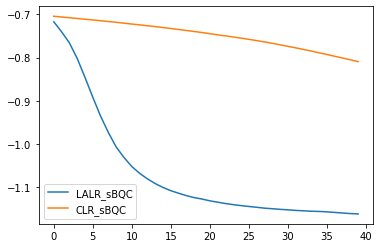

In [51]:
# error plots
# plt.plot(range(10), ls_list_LALR_sBQC)
plt.plot(range(len(val_list_LALR_sBQC)), val_list_LALR_sBQC, label= "LALR_sBQC")
# plt.plot(range(len(ls_list_LALR_sBQC)), ls_list_LALR_sBQC, label= "LALR_sBQC_ls")
plt.plot(range(len(val_list_CLR_sBQC)), val_list_CLR_sBQC, label= "CLR_sBQC")
# plt.plot(range(len(val_list_LALR_sBQC)), val_list_LALR_BCE, label= "LALR_BCE")
# plt.plot(range(len(val_list_CLR_sBQC)), val_list_CLR_BCE, label= "CLR_BCE")
# plt.plot(range(len(acc_list_CLR_BCE)), acc_list_CLR_BCE, label= "CLR_BCE_acc")
# plt.plot(range(len(acc_list_CLR_sBQC)), acc_list_CLR_sBQC, label= "CLR_sBQC_acc")
# plt.plot(range(len(acc_list_LALR_BCE)), acc_list_LALR_BCE, label= "LALR_BCE_acc")
# plt.plot(range(len(acc_list_LALR_sBQC)), acc_list_LALR_sBQC, label= "LALR_sBQC_acc")
plt.legend()

In [65]:
# metrics:
def computeMetrics(model):
    outputs= torch.Tensor([])
    outputs= outputs.to(device)
    labels= torch.Tensor([])
    labels= labels.to(device)
    for inputs, label in test_loader:
        inputs= inputs.to(device)
        label= label.to(device)
        output= model(inputs)
        outputs= torch.cat((outputs, output))
        labels= torch.cat((labels, label))
    x= outputs
    x= torch.where(outputs.view(outputs.shape[0]) > 0.5, 1, 0)
    CP= cohen_kappa_score(labels.detach().to('cpu').numpy(), x.detach().to('cpu').numpy())
    JS= jaccard_score(labels.detach().to('cpu').numpy(), x.detach().to('cpu').numpy())
    F1= f1_score(labels.detach().to('cpu').numpy(), x.detach().to('cpu').numpy())
    return [CP, JS, F1]

In [66]:
computeMetrics(modelLALR_sBQC)

[0.3790322580645161, 0.3474576271186441, 0.5157232704402516]